<a href="https://colab.research.google.com/drive/1BUdJVA9Qry3kXGeyXkKT3o2mRfttEQ8V?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<!--- @wandbcode{pytorch_geometric_example} -->

# Install PyTorch Geometric

In [ ]:
import torch
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Visualization
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 24})

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 31.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done



# Dataset Selection


In [ ]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='.', name='IMDB-BINARY')

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].num_nodes}') # it was x
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Extracting ./IMDB-BINARY/IMDB-BINARY.zip
Processing...


Dataset: IMDB-BINARY(1000)
-------------------
Number of graphs: 1000
Number of nodes: 20
Number of features: 0
Number of classes: 2


Done!



#Graph Show


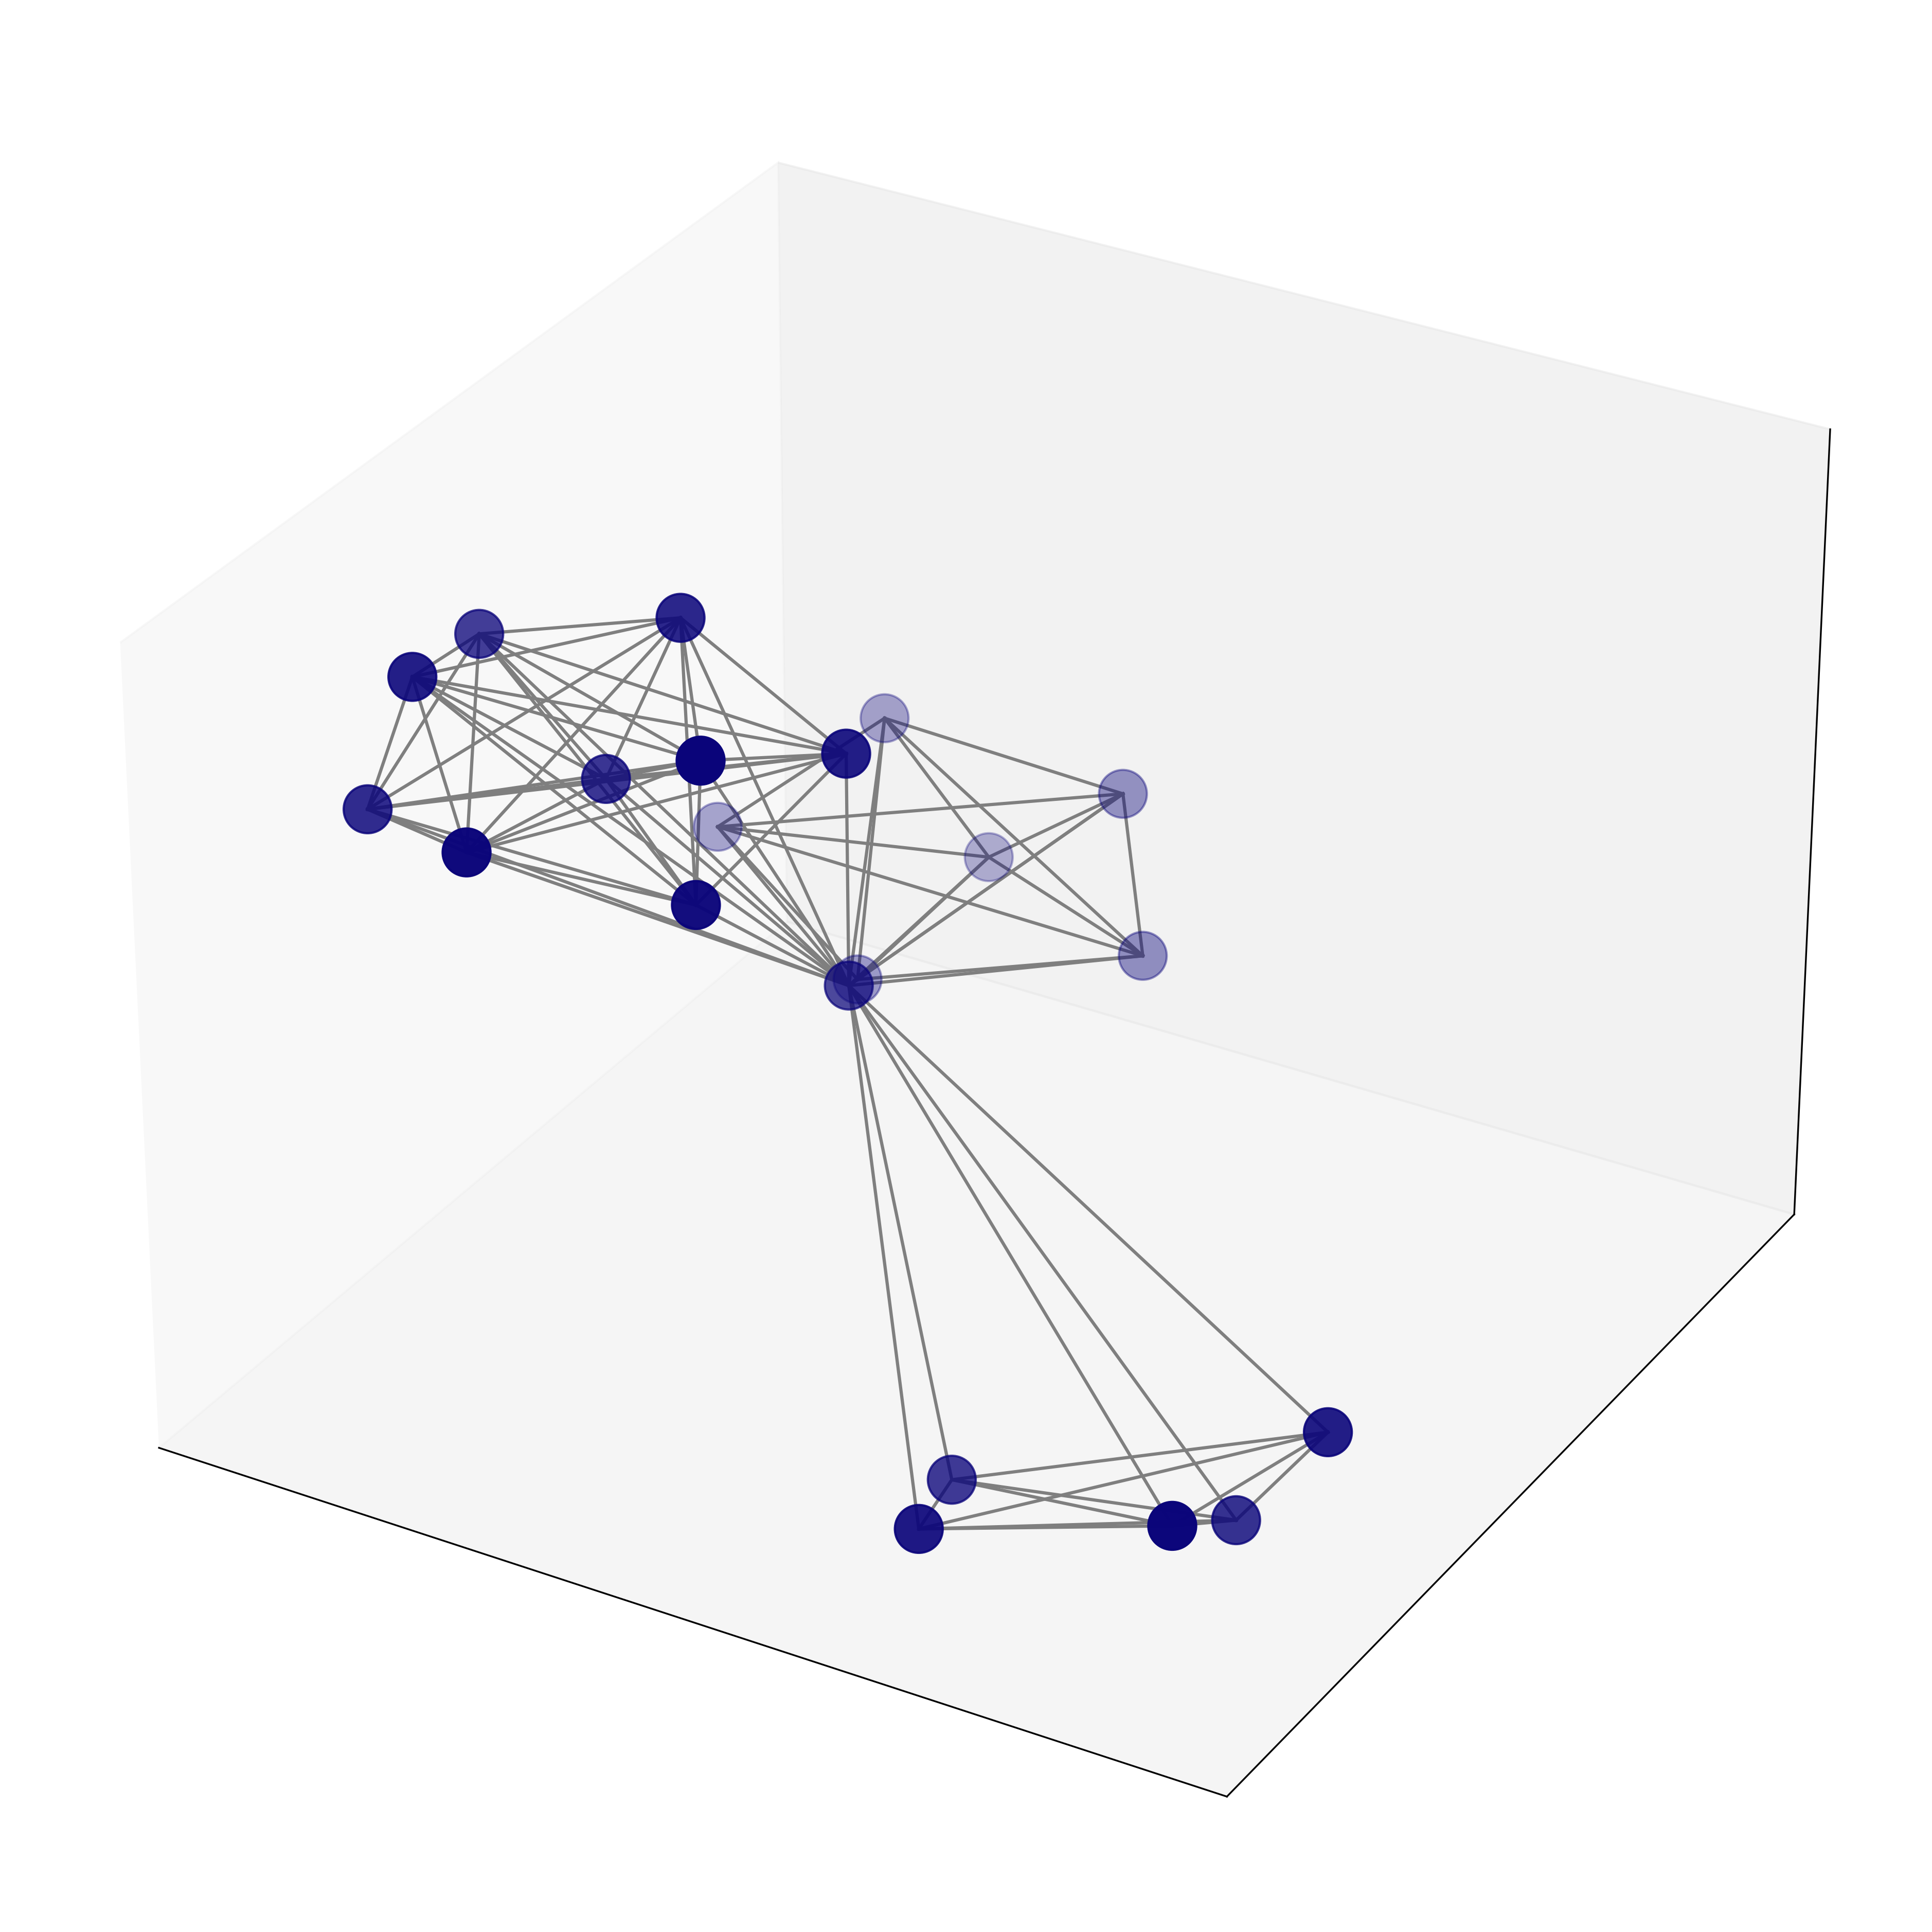

In [ ]:
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

G = to_networkx(dataset[2], to_undirected=True)

# 3D spring layout
pos = nx.spring_layout(G, dim=3, seed=0)

# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection="3d")

# Suppress tick labels
for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
    dim.set_ticks([])

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=500, c="#0A047A")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")

# fig.tight_layout()
plt.show()

#Util.py

In [ ]:
from typing import List, Tuple
from skimage.restoration import denoise_tv_chambolle
import numpy as np
import copy
import torch_geometric.transforms as T
from torch_geometric.utils import degree, to_dense_adj
import torch.nn.functional as F
import torch
import random

from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Data


class NormalizedDegree(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        deg = degree(data.edge_index[0], dtype=torch.float)
        deg = (deg - self.mean) / self.std
        data.x = deg.view(-1, 1)
        # print( data.x.shape )
        return data


def prepare_synthetic_dataset(dataset):
        max_degree = 0
        degs = []
        for data in dataset:
            degs += [degree(data.edge_index[0], dtype=torch.long)]
            max_degree = max(max_degree, degs[-1].max().item())

        for data in dataset:
            degs = degree(data.edge_index[0], dtype=torch.long)

            data.x = F.one_hot(degs.to(torch.int64), num_classes=max_degree+1).to(torch.float)
            print(data.x.shape)


        return dataset


def prepare_dataset(dataset):
    if dataset.data.x is None:
        max_degree = 0
        degs = []
        for data in dataset:
            degs += [degree(data.edge_index[0], dtype=torch.long)]
            max_degree = max(max_degree, degs[-1].max().item())

        if max_degree < 1000:
            dataset.transform = T.OneHotDegree(max_degree)
        else:
            deg = torch.cat(degs, dim=0).to(torch.float)
            mean, std = deg.mean().item(), deg.std().item()
            dataset.transform = NormalizedDegree(mean, std)

    return dataset




def graph_numpy2tensor(graphs: List[np.ndarray]) -> torch.Tensor:
    """
    Convert a list of np arrays to a pytorch tensor
    :param graphs: [K (N, N) adjacency matrices]
    :return:
        graph_tensor: [K, N, N] tensor
    """
    graph_tensor = np.array(graphs)
    return torch.from_numpy(graph_tensor).float()



def align_graphs_modified(graphs: List[np.ndarray],
                 padding: bool = False, N: int = None) -> Tuple[List[np.ndarray], List[np.ndarray], int, int]:
    """
    Align multiple graphs by sorting their nodes by descending node degrees

    :param graphs: a list of binary adjacency matrices
    :param padding: whether padding graphs to the same size or not
    :return:
        aligned_graphs: a list of aligned adjacency matrices
        normalized_node_degrees: a list of sorted normalized node degrees (as node distributions)
    """
    num_nodes = [graphs[i].shape[0] for i in range(len(graphs))]
    max_num = max(num_nodes)
    min_num = min(num_nodes)

    aligned_graphs = []
    normalized_node_degrees = []
    for i in range(len(graphs)):
        num_i = graphs[i].shape[0]

        node_degree = 0.5 * np.sum(graphs[i], axis=0) + 0.5 * np.sum(graphs[i], axis=1)
        node_degree /= np.sum(node_degree)
        idx = np.argsort(node_degree)  # ascending
        idx = idx[::-1]  # descending

        sorted_node_degree = node_degree[idx]
        sorted_node_degree = sorted_node_degree.reshape(-1, 1)

        sorted_graph = copy.deepcopy(graphs[i])
        sorted_graph = sorted_graph[idx, :]
        sorted_graph = sorted_graph[:, idx]

        max_num = max(max_num, N)

        if padding:
            # normalized_node_degree = np.ones((max_num, 1)) / max_num
            normalized_node_degree = np.zeros((max_num, 1))
            normalized_node_degree[:num_i, :] = sorted_node_degree

            aligned_graph = np.zeros((max_num, max_num))
            aligned_graph[:num_i, :num_i] = sorted_graph

            normalized_node_degrees.append(normalized_node_degree)
            aligned_graphs.append(aligned_graph)
        else:
            normalized_node_degrees.append(sorted_node_degree)
            aligned_graphs.append(sorted_graph)

        if N:
            aligned_graphs = [aligned_graph[:N, :N] for aligned_graph in aligned_graphs]
            normalized_node_degrees = normalized_node_degrees[:N]

    return aligned_graphs, normalized_node_degrees, max_num, min_num



def align_x_graphs(graphs: List[np.ndarray], node_x: List[np.ndarray], padding: bool = False, N: int = None) -> Tuple[List[np.ndarray], List[np.ndarray], int, int]:
    """
    Align multiple graphs by sorting their nodes by descending node degrees

    :param graphs: a list of binary adjacency matrices
    :param padding: whether padding graphs to the same size or not
    :return:
        aligned_graphs: a list of aligned adjacency matrices
        normalized_node_degrees: a list of sorted normalized node degrees (as node distributions)
    """
    num_nodes = [graphs[i].shape[0] for i in range(len(graphs))]
    max_num = max(num_nodes)
    min_num = min(num_nodes)

    aligned_graphs = []
    normalized_node_degrees = []
    for i in range(len(graphs)):
        num_i = graphs[i].shape[0]

        node_degree = 0.5 * np.sum(graphs[i], axis=0) + 0.5 * np.sum(graphs[i], axis=1)
        node_degree /= np.sum(node_degree)
        idx = np.argsort(node_degree)  # ascending
        idx = idx[::-1]  # descending

        sorted_node_degree = node_degree[idx]
        sorted_node_degree = sorted_node_degree.reshape(-1, 1)

        sorted_graph = copy.deepcopy(graphs[i])
        sorted_graph = sorted_graph[idx, :]
        sorted_graph = sorted_graph[:, idx]

        node_x = copy.deepcopy( node_x )
        sorted_node_x = node_x[ idx, :]

        max_num = max(max_num, N)
        # if max_num < N:
        #     max_num = max(max_num, N)
        if padding:
            # normalized_node_degree = np.ones((max_num, 1)) / max_num
            normalized_node_degree = np.zeros((max_num, 1))
            normalized_node_degree[:num_i, :] = sorted_node_degree

            aligned_graph = np.zeros((max_num, max_num))
            aligned_graph[:num_i, :num_i] = sorted_graph

            normalized_node_degrees.append(normalized_node_degree)
            aligned_graphs.append(aligned_graph)

            # added
            aligned_node_x = np.zeros((max_num, 1))
            aligned_node_x[:num_i, :] = sorted_node_x


        else:
            normalized_node_degrees.append(sorted_node_degree)
            aligned_graphs.append(sorted_graph)

        if N:
            aligned_graphs = [aligned_graph[:N, :N] for aligned_graph in aligned_graphs]
            normalized_node_degrees = normalized_node_degrees[:N]

            #added
            aligned_node_x = aligned_node_x[:N]

    return aligned_graphs, aligned_node_x, normalized_node_degrees, max_num, min_num





def two_graphons_mixup(two_graphons, la=0.5, num_sample=20):

    label = la * two_graphons[0][0] + (1 - la) * two_graphons[1][0]
    new_graphon = la * two_graphons[0][1] + (1 - la) * two_graphons[1][1]

    sample_graph_label = torch.from_numpy(label).type(torch.float32)
    # print(new_graphon)

    sample_graphs = []
    for i in range(num_sample):

        sample_graph = (np.random.rand(*new_graphon.shape) <= new_graphon).astype(np.int32)
        sample_graph = np.triu(sample_graph)
        sample_graph = sample_graph + sample_graph.T - np.diag(np.diag(sample_graph))

        sample_graph = sample_graph[sample_graph.sum(axis=1) != 0]
        sample_graph = sample_graph[:, sample_graph.sum(axis=0) != 0]

        A = torch.from_numpy(sample_graph)
        edge_index, _ = dense_to_sparse(A)

        num_nodes = int(torch.max(edge_index)) + 1

        pyg_graph = Data()
        pyg_graph.y = sample_graph_label
        pyg_graph.edge_index = edge_index
        pyg_graph.num_nodes = num_nodes
        sample_graphs.append(pyg_graph)

        # print(edge_index)
    return sample_graphs



def two_x_graphons_mixup(two_x_graphons, la=0.5, num_sample=20):

    label = la * two_x_graphons[0][0] + (1 - la) * two_x_graphons[1][0]
    new_graphon = la * two_x_graphons[0][1] + (1 - la) * two_x_graphons[1][1]
    new_x = la * two_x_graphons[0][2] + (1 - la) * two_x_graphons[1][2]

    sample_graph_label = torch.from_numpy(label).type(torch.float32)
    sample_graph_x = torch.from_numpy(new_x).type(torch.float32)
    # print(new_graphon)

    sample_graphs = []
    for i in range(num_sample):

        sample_graph = (np.random.rand(*new_graphon.shape) <= new_graphon).astype(np.int32)
        sample_graph = np.triu(sample_graph)
        sample_graph = sample_graph + sample_graph.T - np.diag(np.diag(sample_graph))

        sample_graph = sample_graph[sample_graph.sum(axis=1) != 0]
        sample_graph = sample_graph[:, sample_graph.sum(axis=0) != 0]

        A = torch.from_numpy(sample_graph)
        edge_index, _ = dense_to_sparse(A)

        num_nodes = int(torch.max(edge_index)) + 1

        pyg_graph = Data()
        pyg_graph.y = sample_graph_label
        pyg_graph.x = sample_graph_x
        pyg_graph.edge_index = edge_index
        pyg_graph.num_nodes = num_nodes
        sample_graphs.append(pyg_graph)

        # print(edge_index)
    return sample_graphs



def graphon_mixup(dataset, la=0.5, num_sample=20):
    graphons = estimate_graphon(dataset, universal_svd)

    two_graphons = random.sample(graphons, 2)
    # for label, graphon in two_graphons:
    #     print( label, graphon )
    # print(two_graphons[0][0])

    label = la * two_graphons[0][0] + (1 - la) * two_graphons[1][0]
    new_graphon = la * two_graphons[0][1] + (1 - la) * two_graphons[1][1]

    print("new label:", label)
    # print("new graphon:", new_graphon)

    # print( label )
    sample_graph_label = torch.from_numpy(label).type(torch.float32)
    # print(new_graphon)

    sample_graphs = []
    for i in range(num_sample):

        sample_graph = (np.random.rand(*new_graphon.shape) < new_graphon).astype(np.int32)
        sample_graph = np.triu(sample_graph)
        sample_graph = sample_graph + sample_graph.T - np.diag(np.diag(sample_graph))

        sample_graph = sample_graph[sample_graph.sum(axis=1) != 0]

        sample_graph = sample_graph[:, sample_graph.sum(axis=0) != 0]

        # print(sample_graph.shape)

        # print(sample_graph)

        A = torch.from_numpy(sample_graph)
        edge_index, _ = dense_to_sparse(A)

        num_nodes = int(torch.max(edge_index)) + 1

        pyg_graph = Data()
        pyg_graph.y = sample_graph_label
        pyg_graph.edge_index = edge_index
        pyg_graph.num_nodes = num_nodes

        sample_graphs.append(pyg_graph)
        # print(edge_index)
    return sample_graphs


def estimate_graphon(dataset, graphon_estimator):

    y_list = []
    for data in dataset:
        y_list.append(tuple(data.y.tolist()))
        # print(y_list)
    num_classes = len(set(y_list))

    all_graphs_list = []
    for graph in dataset:
        adj = to_dense_adj(graph.edge_index)[0].numpy()
        all_graphs_list.append(adj)

    # print(len(all_graphs_list))

    graphons = []
    for class_label in set(y_list):
        c_graph_list = [ all_graphs_list[i] for i in range(len(y_list)) if y_list[i] == class_label ]

        aligned_adj_list, normalized_node_degrees, max_num, min_num = align_graphs(c_graph_list, padding=True, N=400)

        graphon_c = graphon_estimator(aligned_adj_list, threshold=0.2)

        graphons.append((np.array(class_label), graphon_c))

    return graphons



def estimate_one_graphon(aligned_adj_list: List[np.ndarray], method="universal_svd"):

    if method == "universal_svd":
        graphon = universal_svd(aligned_adj_list, threshold=0.2)
    else:
        graphon = universal_svd(aligned_adj_list, threshold=0.2)

    return graphon



def split_class_x_graphs(dataset):

    y_list = []
    for data in dataset:
        y_list.append(tuple(data.y.tolist()))
        # print(y_list)
    num_classes = len(set(y_list))

    all_graphs_list = []
    all_node_x_list = []
    for graph in dataset:
        adj = to_dense_adj(graph.edge_index)[0].numpy()
        all_graphs_list.append(adj)
        all_node_x_list = [graph.x.numpy()]

    class_graphs = []
    for class_label in set(y_list):
        c_graph_list = [all_graphs_list[i] for i in range(len(y_list)) if y_list[i] == class_label]
        c_node_x_list = [all_node_x_list[i] for i in range(len(y_list)) if y_list[i] == class_label]
        class_graphs.append( ( np.array(class_label), c_graph_list, c_node_x_list ) )

    return class_graphs


def split_class_graphs(dataset):

    y_list = []
    for data in dataset:
        y_list.append(tuple(data.y.tolist()))
        # print(y_list)
    num_classes = len(set(y_list))

    all_graphs_list = []
    for graph in dataset:
        adj = to_dense_adj(graph.edge_index)[0].numpy()
        all_graphs_list.append(adj)

    class_graphs = []
    for class_label in set(y_list):
        c_graph_list = [all_graphs_list[i] for i in range(len(y_list)) if y_list[i] == class_label]
        class_graphs.append( ( np.array(class_label), c_graph_list ) )

    return class_graphs




def universal_svd(aligned_graphs: List[np.ndarray], threshold: float = 2.02) -> np.ndarray:
    """
    Estimate a graphon by universal singular value thresholding.

    Reference:
    Chatterjee, Sourav.
    "Matrix estimation by universal singular value thresholding."
    The Annals of Statistics 43.1 (2015): 177-214.

    :param aligned_graphs: a list of (N, N) adjacency matrices
    :param threshold: the threshold for singular values
    :return: graphon: the estimated (r, r) graphon model
    """
    aligned_graphs = graph_numpy2tensor(aligned_graphs).to( "cuda" )
    num_graphs = aligned_graphs.size(0)

    if num_graphs > 1:
        sum_graph = torch.mean(aligned_graphs, dim=0)
    else:
        sum_graph = aligned_graphs[0, :, :]  # (N, N)

    num_nodes = sum_graph.size(0)

    u, s, v = torch.svd(sum_graph)
    singular_threshold = threshold * (num_nodes ** 0.5)
    binary_s = torch.lt(s, singular_threshold)
    s[binary_s] = 0
    graphon = u @ torch.diag(s) @ torch.t(v)
    graphon[graphon > 1] = 1
    graphon[graphon < 0] = 0
    graphon = graphon.cpu().numpy()
    torch.cuda.empty_cache()
    return graphon


def sorted_smooth(aligned_graphs: List[np.ndarray], h: int) -> np.ndarray:
    """
    Estimate a graphon by a sorting and smoothing method

    Reference:
    S. H. Chan and E. M. Airoldi,
    "A Consistent Histogram Estimator for Exchangeable Graph Models",
    Proceedings of International Conference on Machine Learning, 2014.

    :param aligned_graphs: a list of (N, N) adjacency matrices
    :param h: the block size
    :return: a (k, k) step function and  a (r, r) estimation of graphon
    """
    aligned_graphs = graph_numpy2tensor(aligned_graphs)
    num_graphs = aligned_graphs.size(0)

    if num_graphs > 1:
        sum_graph = torch.mean(aligned_graphs, dim=0, keepdim=True).unsqueeze(0)
    else:
        sum_graph = aligned_graphs.unsqueeze(0)  # (1, 1, N, N)

    # histogram of graph
    kernel = torch.ones(1, 1, h, h) / (h ** 2)
    # print(sum_graph.size(), kernel.size())
    graphon = torch.nn.functional.conv2d(sum_graph, kernel, padding=0, stride=h, bias=None)
    graphon = graphon[0, 0, :, :].numpy()
    # total variation denoising
    graphon = denoise_tv_chambolle(graphon, weight=h)
    return graphon


def stat_graph(graphs_list: List[Data]):
    num_total_nodes = []
    num_total_edges = []
    for graph in graphs_list:
        num_total_nodes.append(graph.num_nodes)
        num_total_edges.append(  graph.edge_index.shape[1] )
    avg_num_nodes = sum( num_total_nodes ) / len(graphs_list)
    avg_num_edges = sum( num_total_edges ) / len(graphs_list) / 2.0
    avg_density = avg_num_edges / (avg_num_nodes * avg_num_nodes)

    median_num_nodes = np.median( num_total_nodes )
    median_num_edges = np.median(num_total_edges)
    median_density = median_num_edges / (median_num_nodes * median_num_nodes)

    return avg_num_nodes, avg_num_edges, avg_density, median_num_nodes, median_num_edges, median_density

#Graphon_estimator.py

In [ ]:
# some code are from https://github.com/HongtengXu/SGWB-Graphon

import copy
import cv2
import numpy as np
import torch

from skimage.restoration import denoise_tv_chambolle
from typing import List, Tuple


def graph_numpy2tensor(graphs: List[np.ndarray]) -> torch.Tensor:
    """
    Convert a list of np arrays to a pytorch tensor
    :param graphs: [K (N, N) adjacency matrices]
    :return:
        graph_tensor: [K, N, N] tensor
    """
    graph_tensor = np.array(graphs)
    return torch.from_numpy(graph_tensor).float()


def align_graphs(graphs: List[np.ndarray],
                 padding: bool = False) -> Tuple[List[np.ndarray], List[np.ndarray], int, int]:
    """
    Align multiple graphs by sorting their nodes by descending node degrees

    :param graphs: a list of binary adjacency matrices
    :param padding: whether padding graphs to the same size or not
    :return:
        aligned_graphs: a list of aligned adjacency matrices
        normalized_node_degrees: a list of sorted normalized node degrees (as node distributions)
    """
    num_nodes = [graphs[i].shape[0] for i in range(len(graphs))]
    max_num = max(num_nodes)
    min_num = min(num_nodes)

    aligned_graphs = []
    normalized_node_degrees = []
    for i in range(len(graphs)):
        num_i = graphs[i].shape[0]

        node_degree = 0.5 * np.sum(graphs[i], axis=0) + 0.5 * np.sum(graphs[i], axis=1)
        node_degree /= np.sum(node_degree)
        idx = np.argsort(node_degree)  # ascending
        idx = idx[::-1]  # descending


        sorted_node_degree = node_degree[idx]
        sorted_node_degree = sorted_node_degree.reshape(-1, 1)

        sorted_graph = copy.deepcopy(graphs[i])
        sorted_graph = sorted_graph[idx, :]
        sorted_graph = sorted_graph[:, idx]

        if padding:
            # normalized_node_degree = np.ones((max_num, 1)) / max_num
            normalized_node_degree = np.zeros((max_num, 1))
            normalized_node_degree[:num_i, :] = sorted_node_degree
            aligned_graph = np.zeros((max_num, max_num))
            aligned_graph[:num_i, :num_i] = sorted_graph
            normalized_node_degrees.append(normalized_node_degree)
            aligned_graphs.append(aligned_graph)
        else:
            # normalized_node_degree = np.ones(sorted_node_degree.shape) / sorted_node_degree.shape[0]
            # normalized_node_degrees.append(normalized_node_degree)
            normalized_node_degrees.append(sorted_node_degree)
            aligned_graphs.append(sorted_graph)

    return aligned_graphs, normalized_node_degrees, max_num, min_num


def align_graphs_centrality(graphs: List[np.ndarray],
                 padding: bool = False) -> Tuple[List[np.ndarray], List[np.ndarray], int, int]:
    """
    Align multiple graphs by sorting their nodes by descending node degrees

    :param graphs: a list of binary adjacency matrices
    :param padding: whether padding graphs to the same size or not
    :return:
        aligned_graphs: a list of aligned adjacency matrices
        normalized_node_degrees: a list of sorted normalized node degrees (as node distributions)
    """
    num_nodes = [graphs[i].shape[0] for i in range(len(graphs))]
    max_num = max(num_nodes)
    min_num = min(num_nodes)

    aligned_graphs = []
    normalized_node_degrees = []
    for i in range(len(graphs)):
        num_i = graphs[i].shape[0]

        node_degree = 0.5 * np.sum(graphs[i], axis=0) + 0.5 * np.sum(graphs[i], axis=1)
        node_degree /= np.sum(node_degree)
        idx = np.argsort(node_degree)  # ascending
        idx = idx[::-1]  # descending

        sorted_node_degree = node_degree[idx]
        sorted_node_degree = sorted_node_degree.reshape(-1, 1)

        sorted_graph = copy.deepcopy(graphs[i])
        sorted_graph = sorted_graph[idx, :]
        sorted_graph = sorted_graph[:, idx]

        if padding:
            # normalized_node_degree = np.ones((max_num, 1)) / max_num
            normalized_node_degree = np.zeros((max_num, 1))
            normalized_node_degree[:num_i, :] = sorted_node_degree
            aligned_graph = np.zeros((max_num, max_num))
            aligned_graph[:num_i, :num_i] = sorted_graph
            normalized_node_degrees.append(normalized_node_degree)
            aligned_graphs.append(aligned_graph)
        else:
            # normalized_node_degree = np.ones(sorted_node_degree.shape) / sorted_node_degree.shape[0]
            # normalized_node_degrees.append(normalized_node_degree)
            normalized_node_degrees.append(sorted_node_degree)
            aligned_graphs.append(sorted_graph)

    return aligned_graphs, normalized_node_degrees, max_num, min_num




def estimate_target_distribution(probs: List[np.ndarray], dim_t: int = None) -> np.ndarray:
    """
    Estimate target distribution via the average of sorted source probabilities
    Args:
        probs: a list of node distributions [(n_s, 1) the distribution of source nodes]
        dim_t: the dimension of target distribution
    Returns:
        p_t: (dim_t, 1) vector representing a distribution
    """
    if dim_t is None:
        dim_t = min([probs[i].shape[0] for i in range(len(probs))])

    p_t = np.zeros((dim_t, 1))
    x_t = np.linspace(0, 1, p_t.shape[0])
    for i in range(len(probs)):
        p_s = probs[i][:, 0]
        p_s = np.sort(p_s)[::-1]
        x_s = np.linspace(0, 1, p_s.shape[0])
        p_t_i = np.interp(x_t, x_s, p_s) + 1e-3
        p_t[:, 0] += p_t_i

    p_t /= np.sum(p_t)
    return p_t


def estimate_graphon(graphs: List[np.ndarray], method, args) -> Tuple[np.ndarray, np.ndarray]:
    if method == 'GWB' or method == 'SGWB' or method == 'FGWB' or method == 'SFGWB':
        aligned_graphs, normalized_node_degrees, max_num, min_num = align_graphs(graphs, padding=False)
    else:
        aligned_graphs, normalized_node_degrees, max_num, min_num = align_graphs(graphs, padding=True)

    block_size = int(np.log2(max_num) + 1)
    num_blocks = int(max_num / block_size)
    p_b = estimate_target_distribution(normalized_node_degrees, dim_t=num_blocks)


    stepfunc = universal_svd(aligned_graphs, threshold=args.threshold_usvt)

    graphon = cv2.resize(stepfunc, dsize=(args.r, args.r), interpolation=cv2.INTER_LINEAR)
    return stepfunc, graphon







def universal_svd(aligned_graphs: List[np.ndarray], threshold: float = 2.02) -> np.ndarray:
    """
    Estimate a graphon by universal singular value thresholding.

    Reference:
    Chatterjee, Sourav.
    "Matrix estimation by universal singular value thresholding."
    The Annals of Statistics 43.1 (2015): 177-214.

    :param aligned_graphs: a list of (N, N) adjacency matrices
    :param threshold: the threshold for singular values
    :return: graphon: the estimated (r, r) graphon model
    """
    aligned_graphs = graph_numpy2tensor(aligned_graphs)
    num_graphs = aligned_graphs.size(0)

    if num_graphs > 1:
        sum_graph = torch.mean(aligned_graphs, dim=0)
    else:
        sum_graph = aligned_graphs[0, :, :]  # (N, N)

    num_nodes = sum_graph.size(0)

    u, s, v = torch.svd(sum_graph)
    singular_threshold = threshold * (num_nodes ** 0.5)
    binary_s = torch.lt(s, singular_threshold)
    s[binary_s] = 0
    graphon = u @ torch.diag(s) @ torch.t(v)
    graphon[graphon > 1] = 1
    graphon[graphon < 0] = 0
    graphon = graphon.numpy()
    return graphon





def guess_rank(matrix: torch.Tensor) -> int:
    """
    A function to guess the rank of a matrix
    :param matrix: a torch.Tensor matrix
    :return:
    """
    n = matrix.size(0)
    m = matrix.size(1)
    epsilon = torch.sum(matrix != 0) / ((n * m) ** 0.5)

    u, s, v = torch.svd(matrix, compute_uv=False)
    max_num = min([100, s.size(0)])
    s = s[:max_num]
    s, _ = torch.sort(s, descending=True)
    diff_s1 = s[:-1] - s[1:]
    diff_s1 = diff_s1 / torch.mean(diff_s1[-10:])
    r1 = torch.zeros(1)
    gamma = 0.05
    while r1.item() <= 0:
        cost = torch.zeros(diff_s1.size(0))
        for i in range(diff_s1.size(0)):
            cost[i] = gamma * torch.max(diff_s1[i:]) + i + 1

        idx = torch.argmin(cost)
        r1 = torch.argmax(idx)
        gamma += 0.05

    cost = torch.zeros(diff_s1.size(0))
    for i in range(diff_s1.size(0)):
        cost[i] = s[i + 1] + ((i + 1) * epsilon ** 0.5) * s[0] / epsilon

    idx = torch.argmin(cost)
    r2 = torch.max(idx)
    return max([r1.item(), r2.item()])



def averaging_graphs(aligned_graphs: List[np.ndarray], trans: List[np.ndarray], ws: np.ndarray) -> np.ndarray:
    """
    sum_k w_k * (Tk @ Gk @ Tk')
    :param aligned_graphs: a list of (Ni, Ni) adjacency matrices
    :param trans: a list of (Nb, Ni) transport matrices
    :param ws: (K, ) weights
    :return: averaged_graph: a (Nb, Nb) adjacency matrix
    """
    averaged_graph = 0
    for k in range(ws.shape[0]):
        averaged_graph += ws[k] * (trans[k] @ aligned_graphs[k] @ trans[k].T)
    return averaged_graph


def proximal_ot(cost: np.ndarray,
                p1: np.ndarray,
                p2: np.ndarray,
                iters: int,
                beta: float,
                error_bound: float = 1e-10,
                prior: np.ndarray = None) -> np.ndarray:
    """
    min_{T in Pi(p1, p2)} <cost, T> + beta * KL(T | prior)

    :param cost: (n1, n2) cost matrix
    :param p1: (n1, 1) source distribution
    :param p2: (n2, 1) target distribution
    :param iters: the number of Sinkhorn iterations
    :param beta: the weight of proximal term
    :param error_bound: the relative error bound
    :param prior: the prior of optimal transport matrix T, if it is None, the proximal term degrades to Entropy term
    :return:
        trans: a (n1, n2) optimal transport matrix
    """
    if prior is not None:
        kernel = np.exp(-cost / beta) * prior
    else:
        kernel = np.exp(-cost / beta)

    relative_error = np.inf
    a = np.ones(p1.shape) / p1.shape[0]
    b = []
    i = 0

    while relative_error > error_bound and i < iters:
        b = p2 / (np.matmul(kernel.T, a))
        a_new = p1 / np.matmul(kernel, b)
        relative_error = np.sum(np.abs(a_new - a)) / np.sum(np.abs(a))
        a = copy.deepcopy(a_new)
        i += 1
    trans = np.matmul(a, b.T) * kernel
    return trans


def node_cost_st(cost_s: np.ndarray, cost_t: np.ndarray, p_s: np.ndarray, p_t: np.ndarray) -> np.ndarray:
    """
    Calculate invariant cost between the nodes in different graphs based on learned optimal transport
    Args:
        cost_s: (n_s, n_s) array, the cost matrix of source graph
        cost_t: (n_t, n_t) array, the cost matrix of target graph
        p_s: (n_s, 1) array, the distribution of source nodes
        p_t: (n_t, 1) array, the distribution of target nodes
    Returns:
        cost_st: (n_s, n_t) array, the estimated invariant cost between the nodes in two graphs
    """
    n_s = cost_s.shape[0]
    n_t = cost_t.shape[0]
    f1_st = np.repeat((cost_s ** 2) @ p_s, n_t, axis=1)
    f2_st = np.repeat(((cost_t ** 2) @ p_t).T, n_s, axis=0)
    cost_st = f1_st + f2_st
    return cost_st


def gw_cost(cost_s: np.ndarray, cost_t: np.ndarray, trans: np.ndarray, p_s: np.ndarray, p_t: np.ndarray) -> np.ndarray:
    """
    Calculate the cost between the nodes in different graphs based on learned optimal transport
    Args:
        cost_s: (n_s, n_s) array, the cost matrix of source graph
        cost_t: (n_t, n_t) array, the cost matrix of target graph
        trans: (n_s, n_t) array, the learned optimal transport between two graphs
        p_s: (n_s, 1) array, the distribution of source nodes
        p_t: (n_t, 1) array, the distribution of target nodes
    Returns:
        cost: (n_s, n_t) array, the estimated cost between the nodes in two graphs
    """
    cost_st = node_cost_st(cost_s, cost_t, p_s, p_t)
    return cost_st - 2 * (cost_s @ trans @ cost_t.T)

#Model.py

In [ ]:
from torch_geometric.nn import GINConv, global_mean_pool, JumpingKnowledge
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d as BN
from math import ceil
from torch_geometric.nn import DenseSAGEConv, dense_diff_pool, JumpingKnowledge
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool, JumpingKnowledge
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import SAGEConv, global_mean_pool, JumpingKnowledge
import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.nn import GraphConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from math import ceil

import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv, DenseGraphConv, dense_mincut_pool, dense_diff_pool
from torch_geometric.utils import to_dense_batch, to_dense_adj


class GIN(torch.nn.Module):
    def __init__(self, num_features=1, num_classes=1, num_hidden=32):
        super(GIN, self).__init__()

        # if data.x is None:
        #   data.x = torch.ones([data.num_nodes, 1], dtype=torch.float)
        # dataset.data.edge_attr = None

        # num_features = dataset.num_features
        dim = num_hidden

        nn1 = Sequential(Linear(num_features, dim), ReLU(), Linear(dim, dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(dim)

        nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(dim)

        nn3 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv3 = GINConv(nn3)
        self.bn3 = torch.nn.BatchNorm1d(dim)

        nn4 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv4 = GINConv(nn4)
        self.bn4 = torch.nn.BatchNorm1d(dim)

        nn5 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv5 = GINConv(nn5)
        self.bn5 = torch.nn.BatchNorm1d(dim)

        self.fc1 = Linear(dim, dim)
        self.fc2 = Linear(dim, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = F.relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        x = F.relu(self.conv5(x, edge_index))
        x = self.bn5(x)
        # x = global_add_pool(x, batch)
        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

#Gmixup.py

In [ ]:
from time import time
import logging
#import os
#import os.path as osp
import numpy as np
import time

import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.utils import degree
from torch.autograd import Variable

import random
from torch.optim.lr_scheduler import StepLR


#from utils import stat_graph, split_class_graphs, align_graphs
#from utils import two_graphons_mixup, universal_svd
#from graphon_estimator import universal_svd
#from models import GIN

import argparse

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(levelname)s: - %(message)s', datefmt='%Y-%m-%d')



def prepare_dataset_x(dataset):
    if dataset[0].x is None:
        max_degree = 0
        degs = []
        for data in dataset:
            degs += [degree(data.edge_index[0], dtype=torch.long)]
            max_degree = max( max_degree, degs[-1].max().item() )
            data.num_nodes = int( torch.max(data.edge_index) ) + 1

        if max_degree < 2000:
            # dataset.transform = T.OneHotDegree(max_degree)

            for data in dataset:
                degs = degree(data.edge_index[0], dtype=torch.long)
                data.x = F.one_hot(degs, num_classes=max_degree+1).to(torch.float)
        else:
            deg = torch.cat(degs, dim=0).to(torch.float)
            mean, std = deg.mean().item(), deg.std().item()
            for data in dataset:
                degs = degree(data.edge_index[0], dtype=torch.long)
                data.x = ( (degs - mean) / std ).view( -1, 1 )
    return dataset



def prepare_dataset_onehot_y(dataset):

    y_set = set()
    for data in dataset:
        y_set.add(int(data.y))
    num_classes = len(y_set)

    for data in dataset:
        data.y = F.one_hot(data.y, num_classes=num_classes).to(torch.float)[0]
    return dataset


def mixup_cross_entropy_loss(input, target, size_average=True):
    """Origin: https://github.com/moskomule/mixup.pytorch
    in PyTorch's cross entropy, targets are expected to be labels
    so to predict probabilities this loss is needed
    suppose q is the target and p is the input
    loss(p, q) = -\sum_i q_i \log p_i
    """
    assert input.size() == target.size()
    assert isinstance(input, Variable) and isinstance(target, Variable)
    loss = - torch.sum(input * target)
    return loss / input.size()[0] if size_average else loss




def train(model, train_loader):
    model.train()
    loss_all = 0
    graph_all = 0
    for data in train_loader:
        # print( "data.y", data.y )
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        y = data.y.view(-1, num_classes)
        loss = mixup_cross_entropy_loss(output, y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        graph_all += data.num_graphs
        optimizer.step()
    loss = loss_all / graph_all
    return model, loss


def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    loss = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        y = data.y.view(-1, num_classes)
        loss += mixup_cross_entropy_loss(output, y).item() * data.num_graphs
        y = y.max(dim=1)[1]
        correct += pred.eq(y).sum().item()
        total += data.num_graphs
    acc = correct / total
    loss = loss / total
    return acc, loss

#Calling Gmixup.py

In [ ]:
lam_range = [0.005, 0.01]
gmixup = True
num_epochs = 200

num_hidden = 64
batch_size = 32
learning_rate = 0.01
ge = "MC"
aug_ratio = 0.15
aug_num = 10
model = "GIN"
device = "cpu"

dataset = list(dataset)

for graph in dataset:
    graph.y = graph.y.view(-1)

dataset = prepare_dataset_onehot_y(dataset)

random.shuffle( dataset )

train_nums = int(len(dataset) * 0.7)
train_val_nums = int(len(dataset) * 0.8)

avg_num_nodes, avg_num_edges, avg_density, median_num_nodes, median_num_edges, median_density = stat_graph(dataset[: train_nums])
print(f"avg num nodes of training graphs: { avg_num_nodes }")
print(f"avg num edges of training graphs: { avg_num_edges }")
print(f"avg density of training graphs: { avg_density }")
print(f"median num nodes of training graphs: { median_num_nodes }")
print(f"median num edges of training graphs: { median_num_edges }")
print(f"median density of training graphs: { median_density }")

resolution = int(median_num_nodes)

if gmixup == True:
    class_graphs = split_class_graphs(dataset[:train_nums])
    graphons = []
    for label, graphs in class_graphs:

            print(f"label: {label}, num_graphs:{len(graphs)}" )
            align_graphs_list, normalized_node_degrees, max_num, min_num = align_graphs_modified(
                graphs, padding=True, N=resolution)
            print(f"aligned graph {align_graphs_list[0].shape}" )

            print(f"ge: {ge}")
            graphon = universal_svd(align_graphs_list, threshold=0.2)
            graphons.append((label, graphon))


    for label, graphon in graphons:
        print(f"graphon info: label:{label}; mean: {graphon.mean()}, shape, {graphon.shape}")

    num_sample = int( train_nums * aug_ratio / aug_num )
    lam_list = np.random.uniform(low=lam_range[0], high=lam_range[1], size=(aug_num,))

    new_graph = []
    for lam in lam_list:
        print( f"lam: {lam}" )
        print(f"num_sample: {num_sample}")
        two_graphons = random.sample(graphons, 2)
        new_graph += two_graphons_mixup(two_graphons, la=lam, num_sample=num_sample)
        print(f"label: {new_graph[-1].y}")

    avg_num_nodes, avg_num_edges, avg_density, median_num_nodes, median_num_edges, median_density = stat_graph(new_graph)
    print(f"avg num nodes of new graphs: { avg_num_nodes }")
    print(f"avg num edges of new graphs: { avg_num_edges }")
    print(f"avg density of new graphs: { avg_density }")
    print(f"median num nodes of new graphs: { median_num_nodes }")
    print(f"median num edges of new graphs: { median_num_edges }")
    print(f"median density of new graphs: { median_density }")

    dataset = new_graph + dataset
    print( f"real aug ratio: {len( new_graph ) / train_nums }" )
    train_nums = train_nums + len( new_graph )
    train_val_nums = train_val_nums + len( new_graph )

dataset = prepare_dataset_x( dataset )

print(f"num_features: {dataset[0].x.shape}" )
print(f"num_classes: {dataset[0].y.shape}"  )

num_features = dataset[0].x.shape[1]
num_classes = dataset[0].y.shape[0]

train_dataset = dataset[:train_nums]
random.shuffle(train_dataset)
val_dataset = dataset[train_nums:train_val_nums]
test_dataset = dataset[train_val_nums:]

print(f"train_dataset size: {len(train_dataset)}")
print(f"val_dataset size: {len(val_dataset)}")
print(f"test_dataset size: {len(test_dataset)}" )


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


if model == "GIN":
    model = GIN(num_features=num_features, num_classes=num_classes, num_hidden=num_hidden).to(device)
else:
    print(f"No model."  )


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=100, gamma=0.5)

total_acc = 0
for epoch in range(1, num_epochs):
    model, train_loss = train(model, train_loader)
    train_acc = 0
    val_acc, val_loss = test(model, val_loader)
    test_acc, test_loss = test(model, test_loader)
    total_acc += test_acc
    scheduler.step()

    print('Epoch: {:03d}, Train Loss: {:.6f}, Val Loss: {:.6f}, Test Loss: {:.6f},  Val Acc: {: .6f}, Test Acc: {: .6f}'.format(
        epoch, train_loss, val_loss, test_loss, val_acc, test_acc))

print(f'\n Avg Accuracy:     {(total_acc / num_epochs)*100:.2f}%')

avg num nodes of training graphs: 19.80857142857143
avg num edges of training graphs: 96.93571428571428
avg density of training graphs: 0.24704581605700385
median num nodes of training graphs: 17.0
median num edges of training graphs: 130.0
median density of training graphs: 0.44982698961937717
label: [0. 1.], num_graphs:349
aligned graph (17, 17)
ge: MC
label: [1. 0.], num_graphs:351
aligned graph (17, 17)
ge: MC
graphon info: label:[0. 1.]; mean: 0.4067195951938629, shape, (17, 17)
graphon info: label:[1. 0.]; mean: 0.46397411823272705, shape, (17, 17)
lam: 0.005394246090838111
num_sample: 10
label: tensor([0.0054, 0.9946])
lam: 0.00752537221808843
num_sample: 10
label: tensor([0.9925, 0.0075])
lam: 0.00878629254915557
num_sample: 10
label: tensor([0.0088, 0.9912])
lam: 0.0053745075916401056
num_sample: 10
label: tensor([0.9946, 0.0054])
lam: 0.008110152119824647
num_sample: 10
label: tensor([0.0081, 0.9919])
lam: 0.007493949553044984
num_sample: 10
label: tensor([0.0075, 0.9925])
la

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 001, Train Loss: 0.690506, Val Loss: 0.559949, Test Loss: 0.580395,  Val Acc:  0.710000, Test Acc:  0.675000
Epoch: 002, Train Loss: 0.636520, Val Loss: 0.601323, Test Loss: 0.573088,  Val Acc:  0.640000, Test Acc:  0.695000
Epoch: 003, Train Loss: 0.638987, Val Loss: 0.786741, Test Loss: 0.744859,  Val Acc:  0.660000, Test Acc:  0.625000
Epoch: 004, Train Loss: 0.625087, Val Loss: 0.517813, Test Loss: 0.583313,  Val Acc:  0.770000, Test Acc:  0.680000
Epoch: 005, Train Loss: 0.597739, Val Loss: 0.546517, Test Loss: 0.571502,  Val Acc:  0.710000, Test Acc:  0.665000
Epoch: 006, Train Loss: 0.582324, Val Loss: 0.519320, Test Loss: 0.560096,  Val Acc:  0.740000, Test Acc:  0.660000
Epoch: 007, Train Loss: 0.584029, Val Loss: 0.547063, Test Loss: 0.593188,  Val Acc:  0.750000, Test Acc:  0.645000
Epoch: 008, Train Loss: 0.554498, Val Loss: 0.478842, Test Loss: 0.550496,  Val Acc:  0.800000, Test Acc:  0.665000
Epoch: 009, Train Loss: 0.555176, Val Loss: 0.569770, Test Loss: 0.56713